In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, roc_curve, precision_recall_curve
)

# Create reports directory if it doesn't exist
os.makedirs('../reports', exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Data and Models

In [2]:
# Load Data (same split as training)
df = pd.read_csv("../data/processed/train_final.csv")

drop_cols = ["PotentialFraud", "Provider"]
X = df.drop(columns=drop_cols)
y = df["PotentialFraud"].astype(int)

# IMPORTANT: Use same random_state as 02_modeling.ipynb
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"Fraud rate - Train: {y_train.mean():.2%}, Val: {y_val.mean():.2%}, Test: {y_test.mean():.2%}")

Train: 4328, Val: 541, Test: 541
Fraud rate - Train: 9.36%, Val: 9.43%, Test: 9.24%


In [3]:
# Load Saved Models
models = {}
thresholds = {}

try:
    models['Logistic Regression'] = joblib.load('../models/logistic_regression_cal.joblib')
    models['Random Forest'] = joblib.load('../models/random_forest_cal.joblib')
    models['Gradient Boosting'] = joblib.load('../models/gradient_boosting_cal.joblib')
    models['XGBoost'] = joblib.load('../models/xgboost_cal.joblib')
    thresholds = joblib.load('../models/thresholds.joblib')
    print("✅ All models loaded successfully!")
    for name in models:
        print(f"  - {name}: threshold = {thresholds.get(name, 0.5):.4f}")
except FileNotFoundError as e:
    print("❌ Models not found. Please run 02_modeling.ipynb first and save models.")
    print(f"Error: {e}")

✅ All models loaded successfully!
  - Logistic Regression: threshold = 0.3382
  - Random Forest: threshold = 0.2014
  - Gradient Boosting: threshold = 0.4757
  - XGBoost: threshold = 0.5218


In [4]:
# Generate Predictions for All Models
predictions = {}

for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    thresh = thresholds.get(name, 0.5)
    preds = (probs >= thresh).astype(int)
    predictions[name] = {
        'probs': probs,
        'preds': preds,
        'threshold': thresh
    }
    print(f"{name}: {preds.sum()} fraud predictions ({preds.mean():.1%})")

Logistic Regression: 155 fraud predictions (28.7%)
Random Forest: 88 fraud predictions (16.3%)
Gradient Boosting: 115 fraud predictions (21.3%)
XGBoost: 103 fraud predictions (19.0%)
Random Forest: 88 fraud predictions (16.3%)
Gradient Boosting: 115 fraud predictions (21.3%)
XGBoost: 103 fraud predictions (19.0%)


## 2. ROC Curve Comparison

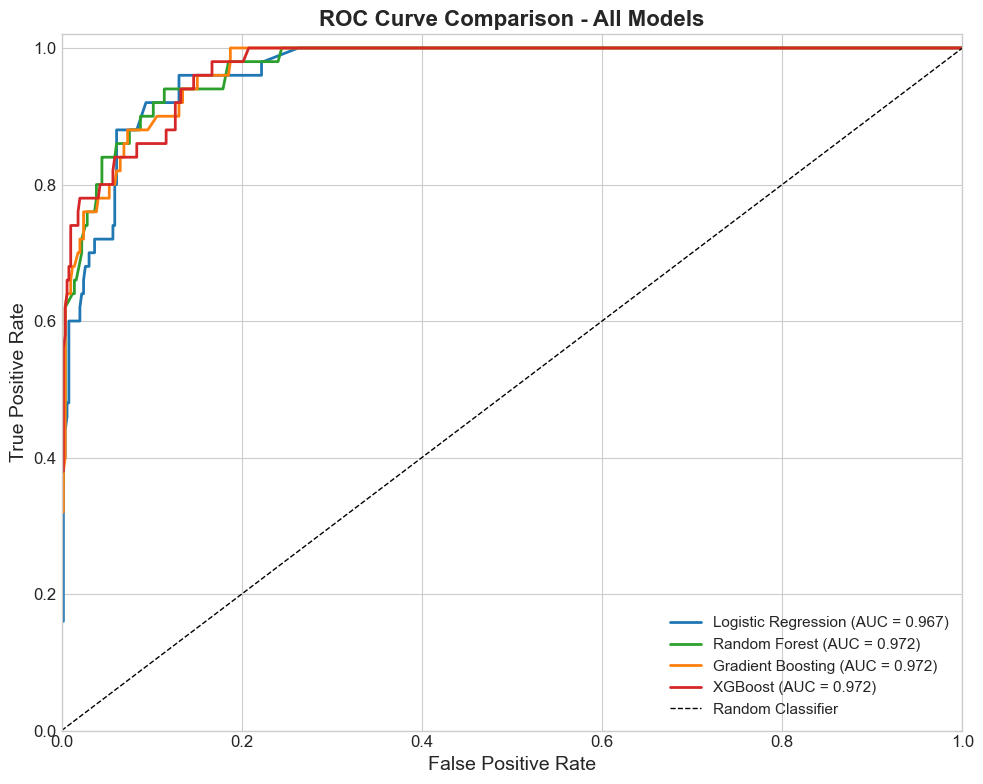

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

for (name, model), color in zip(models.items(), colors):
    probs = predictions[name]['probs']
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('ROC Curve Comparison - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig('../reports/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Precision-Recall Curve Comparison

Critical for imbalanced fraud detection - shows trade-off between catching fraud and false alarms.

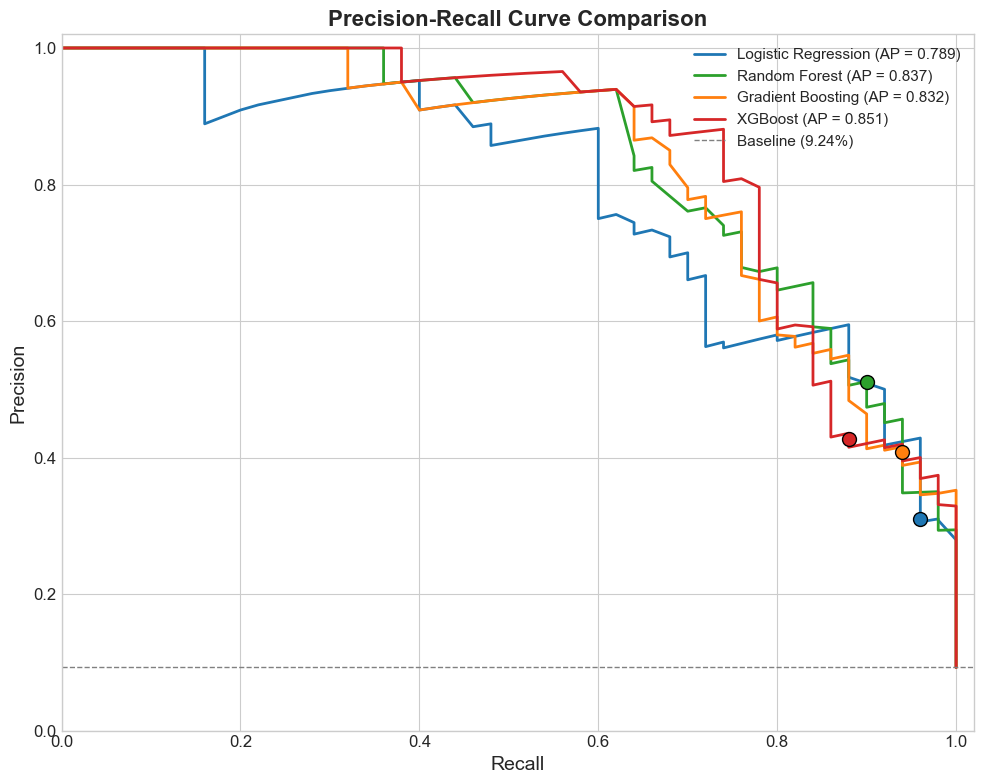

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

for (name, model), color in zip(models.items(), colors):
    probs = predictions[name]['probs']
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    ax.plot(recall, precision, label=f'{name} (AP = {ap:.3f})', color=color, linewidth=2)
    
    # Mark the operating threshold point
    thresh = predictions[name]['threshold']
    pred_at_thresh = (probs >= thresh).astype(int)
    p = precision_score(y_test, pred_at_thresh)
    r = recall_score(y_test, pred_at_thresh)
    ax.scatter([r], [p], color=color, s=100, zorder=5, edgecolor='black')

# Baseline (random classifier)
baseline = y_test.mean()
ax.axhline(y=baseline, color='gray', linestyle='--', label=f'Baseline ({baseline:.2%})', linewidth=1)

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.set_title('Precision-Recall Curve Comparison', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig('../reports/precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Confusion Matrices

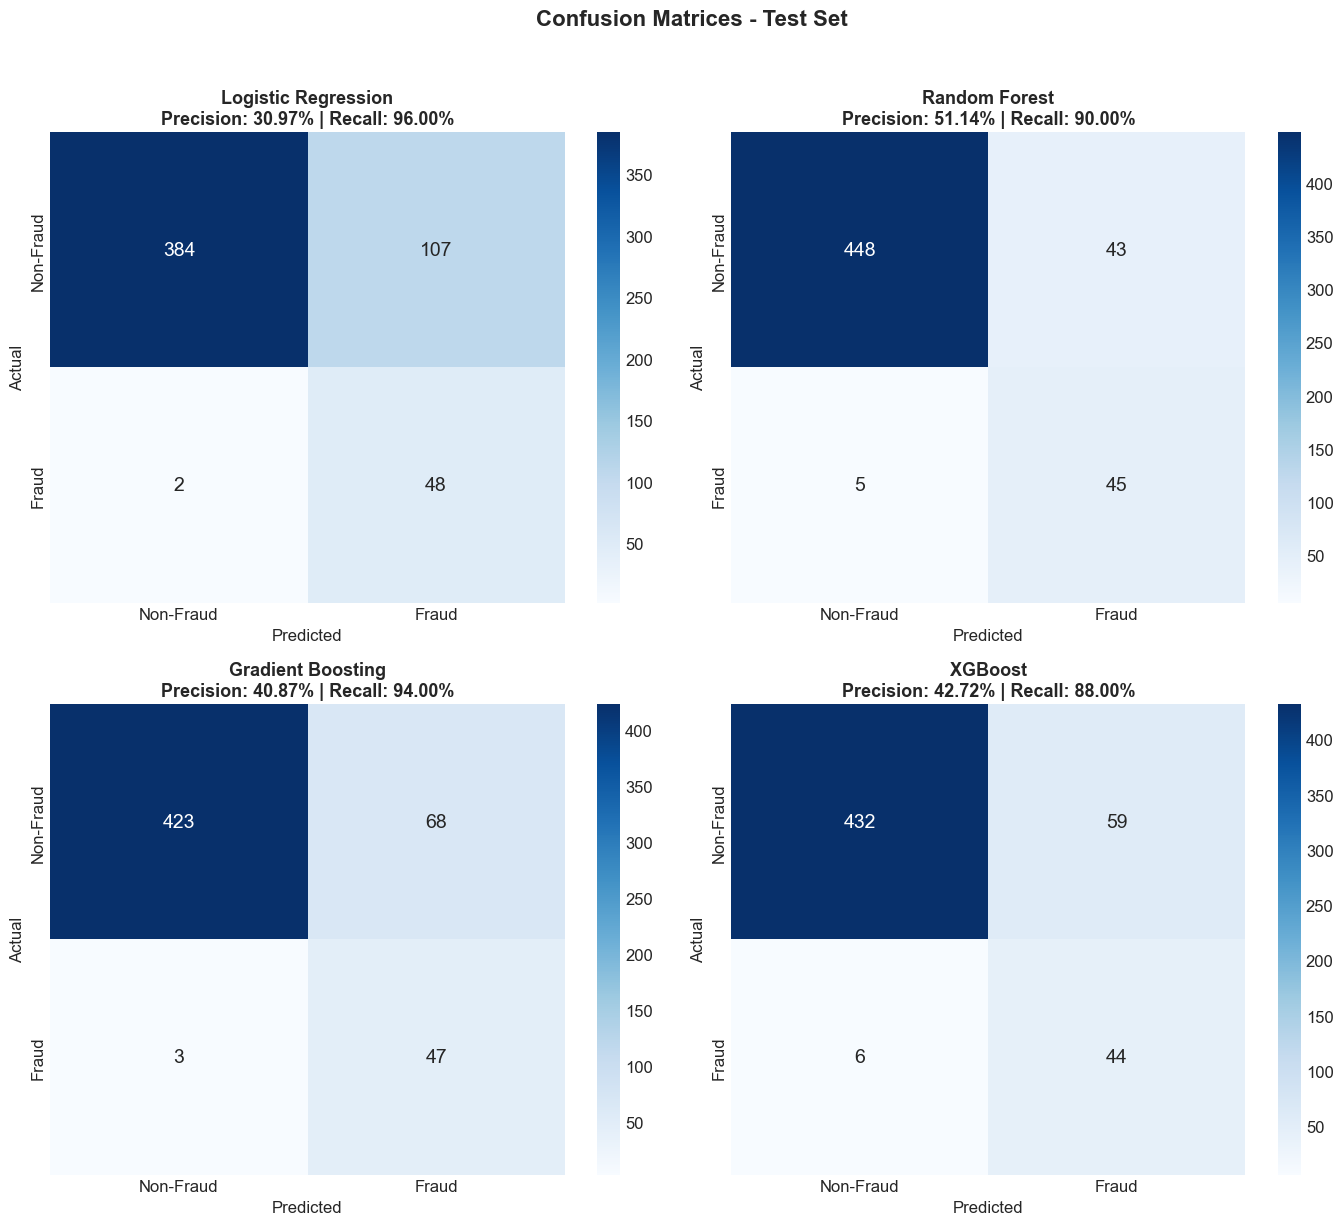

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, pred_dict) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred_dict['preds'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                annot_kws={'size': 14})
    
    axes[idx].set_xlabel('Predicted', fontsize=12)
    axes[idx].set_ylabel('Actual', fontsize=12)
    
    prec = precision_score(y_test, pred_dict['preds'])
    rec = recall_score(y_test, pred_dict['preds'])
    axes[idx].set_title(f'{name}\nPrecision: {prec:.2%} | Recall: {rec:.2%}', 
                        fontsize=13, fontweight='bold')

plt.suptitle('Confusion Matrices - Test Set', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Importance (Random Forest)

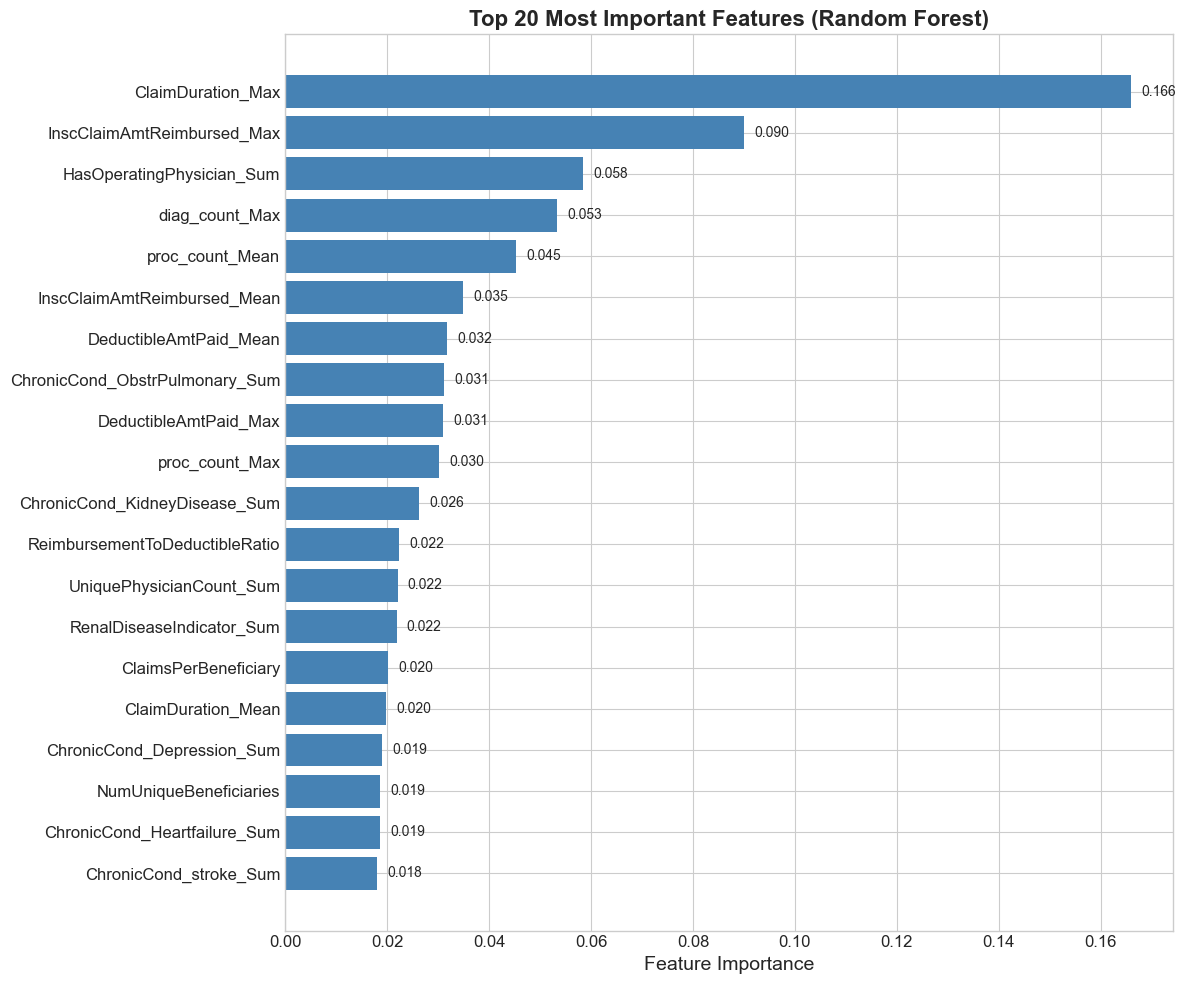


Top 10 Features:
                       feature  importance
             ClaimDuration_Max    0.165897
    InscClaimAmtReimbursed_Max    0.089944
     HasOperatingPhysician_Sum    0.058377
                diag_count_Max    0.053287
               proc_count_Mean    0.045231
   InscClaimAmtReimbursed_Mean    0.034956
        DeductibleAmtPaid_Mean    0.031751
ChronicCond_ObstrPulmonary_Sum    0.031125
         DeductibleAmtPaid_Max    0.030943
                proc_count_Max    0.030221


In [8]:
# Get feature importance from Random Forest
rf_model = models['Random Forest']

# Access the base estimator (the calibrated model wraps the original)
if hasattr(rf_model, 'estimator'):
    base_rf = rf_model.estimator
elif hasattr(rf_model, 'calibrated_classifiers_'):
    base_rf = rf_model.calibrated_classifiers_[0].estimator
else:
    base_rf = rf_model

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': base_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 20
top_features = feature_importance.head(top_n)

bars = ax.barh(range(top_n), top_features['importance'], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=16, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'] + 0.002, i, f'{row["importance"]:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## 6. Model Comparison Summary

In [9]:
results = []

for name, pred_dict in predictions.items():
    probs = pred_dict['probs']
    preds = pred_dict['preds']
    
    results.append({
        'Model': name,
        'Threshold': pred_dict['threshold'],
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds),
        'ROC AUC': roc_auc_score(y_test, probs),
        'Avg Precision': average_precision_score(y_test, probs)
    })

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.round(4)

# Style the dataframe
print("=" * 90)
print("MODEL COMPARISON - TEST SET RESULTS")
print("=" * 90)
print(comparison_df.to_string(index=False))
print("=" * 90)

# Find best model for each metric
print("\n🏆 Best Model by Metric:")
for col in ['Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Avg Precision']:
    best_idx = comparison_df[col].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_val = comparison_df.loc[best_idx, col]
    print(f"  {col}: {best_model} ({best_val:.4f})")

# Save comparison
comparison_df.to_csv('../reports/model_comparison.csv', index=False)

MODEL COMPARISON - TEST SET RESULTS
              Model  Threshold  Precision  Recall  F1-Score  ROC AUC  Avg Precision
Logistic Regression     0.3382     0.3097    0.96    0.4683   0.9673         0.7895
      Random Forest     0.2014     0.5114    0.90    0.6522   0.9722         0.8370
  Gradient Boosting     0.4757     0.4087    0.94    0.5697   0.9717         0.8321
            XGBoost     0.5218     0.4272    0.88    0.5752   0.9725         0.8515

🏆 Best Model by Metric:
  Precision: Random Forest (0.5114)
  Recall: Logistic Regression (0.9600)
  F1-Score: Random Forest (0.6522)
  ROC AUC: XGBoost (0.9725)
  Avg Precision: XGBoost (0.8515)


## 7. Threshold Analysis

Shows how precision, recall, and F1-score change across different decision thresholds. Critical for choosing the optimal operating point.

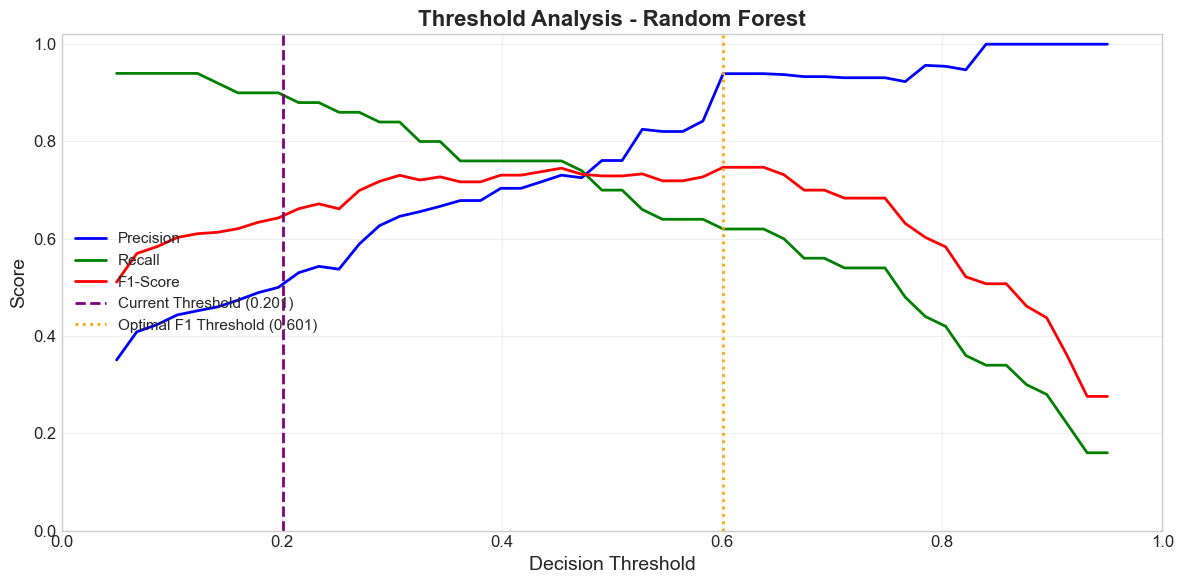


Current threshold: 0.2014
  Precision: 0.5000
  Recall: 0.9000
  F1: 0.6429

Optimal F1 threshold: 0.6010
  Precision: 0.9394
  Recall: 0.6200
  F1: 0.7470


In [12]:
# Threshold Analysis for Random Forest (best model)
rf_probs = predictions['Random Forest']['probs']

thresholds_range = np.linspace(0.05, 0.95, 50)
precision_list = []
recall_list = []
f1_list = []

for t in thresholds_range:
    preds_t = (rf_probs >= t).astype(int)
    if preds_t.sum() > 0:  # Avoid division by zero
        precision_list.append(precision_score(y_test, preds_t, zero_division=0))
        recall_list.append(recall_score(y_test, preds_t))
        f1_list.append(f1_score(y_test, preds_t, zero_division=0))
    else:
        precision_list.append(0)
        recall_list.append(0)
        f1_list.append(0)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds_range, precision_list, 'b-', label='Precision', linewidth=2)
ax.plot(thresholds_range, recall_list, 'g-', label='Recall', linewidth=2)
ax.plot(thresholds_range, f1_list, 'r-', label='F1-Score', linewidth=2)

# Mark current threshold
current_thresh = predictions['Random Forest']['threshold']
ax.axvline(x=current_thresh, color='purple', linestyle='--', linewidth=2, 
           label=f'Current Threshold ({current_thresh:.3f})')

# Find optimal F1 threshold
optimal_idx = np.argmax(f1_list)
optimal_thresh = thresholds_range[optimal_idx]
ax.axvline(x=optimal_thresh, color='orange', linestyle=':', linewidth=2,
           label=f'Optimal F1 Threshold ({optimal_thresh:.3f})')

ax.set_xlabel('Decision Threshold', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Threshold Analysis - Random Forest', fontsize=16, fontweight='bold')
ax.legend(loc='center left', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCurrent threshold: {current_thresh:.4f}")
print(f"  Precision: {precision_list[np.abs(thresholds_range - current_thresh).argmin()]:.4f}")
print(f"  Recall: {recall_list[np.abs(thresholds_range - current_thresh).argmin()]:.4f}")
print(f"  F1: {f1_list[np.abs(thresholds_range - current_thresh).argmin()]:.4f}")
print(f"\nOptimal F1 threshold: {optimal_thresh:.4f}")
print(f"  Precision: {precision_list[optimal_idx]:.4f}")
print(f"  Recall: {recall_list[optimal_idx]:.4f}")
print(f"  F1: {f1_list[optimal_idx]:.4f}")

## 8. Calibration Curve

Shows how well the predicted probabilities match actual outcomes. A well-calibrated model means if it predicts 70% probability, ~70% of those cases should be actual fraud.

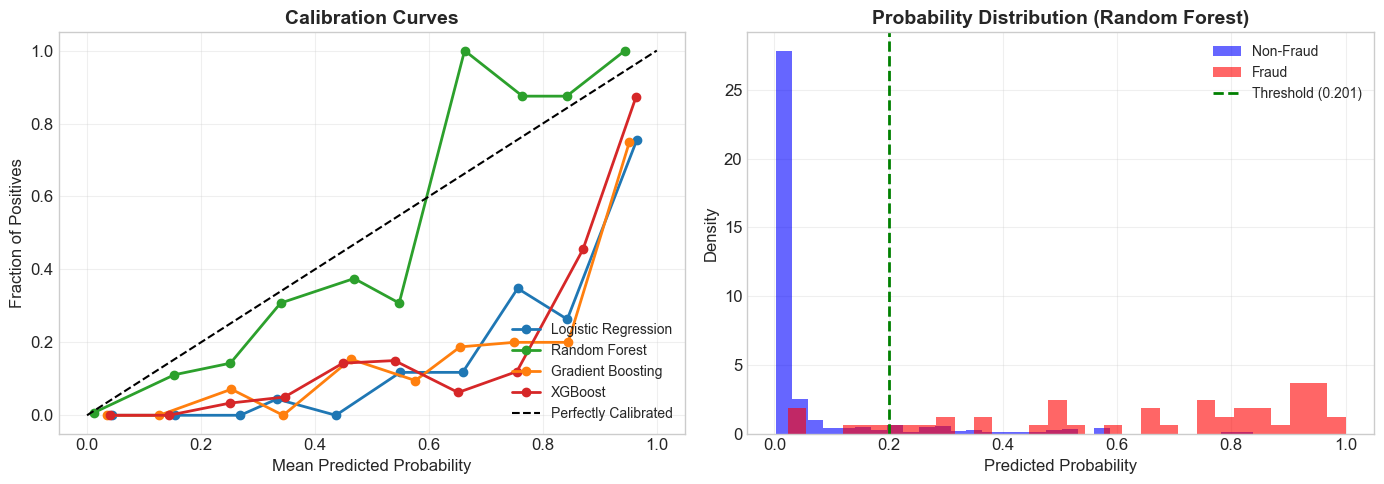


Brier Score (lower is better, 0 is perfect):
  Logistic Regression: 0.0951
  Random Forest: 0.0340
  Gradient Boosting: 0.0833
  XGBoost: 0.0820


In [13]:
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curves for all models
ax1 = axes[0]
for (name, model), color in zip(models.items(), colors):
    probs = predictions[name]['probs']
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10, strategy='uniform')
    ax1.plot(prob_pred, prob_true, marker='o', label=name, color=color, linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
ax1.set_ylabel('Fraction of Positives', fontsize=12)
ax1.set_title('Calibration Curves', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Histogram of predicted probabilities (Random Forest)
ax2 = axes[1]
rf_probs = predictions['Random Forest']['probs']
ax2.hist(rf_probs[y_test == 0], bins=30, alpha=0.6, label='Non-Fraud', color='blue', density=True)
ax2.hist(rf_probs[y_test == 1], bins=30, alpha=0.6, label='Fraud', color='red', density=True)
ax2.axvline(x=predictions['Random Forest']['threshold'], color='green', linestyle='--', 
            linewidth=2, label=f"Threshold ({predictions['Random Forest']['threshold']:.3f})")
ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Probability Distribution (Random Forest)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/calibration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate Brier Score (lower is better)
from sklearn.metrics import brier_score_loss
print("\nBrier Score (lower is better, 0 is perfect):")
for name in models:
    brier = brier_score_loss(y_test, predictions[name]['probs'])
    print(f"  {name}: {brier:.4f}")

## 9. Bootstrap Confidence Intervals

Provides uncertainty estimates for our metrics using bootstrap resampling. Shows how stable our results are.

Bootstrap 95% Confidence Intervals (Random Forest)
Precision      : 0.5117 [0.4024 - 0.6143]
Recall         : 0.9011 [0.8148 - 0.9792]
F1             : 0.6509 [0.5517 - 0.7389]
Roc_auc        : 0.9724 [0.9563 - 0.9869]
Avg_precision  : 0.8382 [0.7464 - 0.9115]
Precision      : 0.5117 [0.4024 - 0.6143]
Recall         : 0.9011 [0.8148 - 0.9792]
F1             : 0.6509 [0.5517 - 0.7389]
Roc_auc        : 0.9724 [0.9563 - 0.9869]
Avg_precision  : 0.8382 [0.7464 - 0.9115]


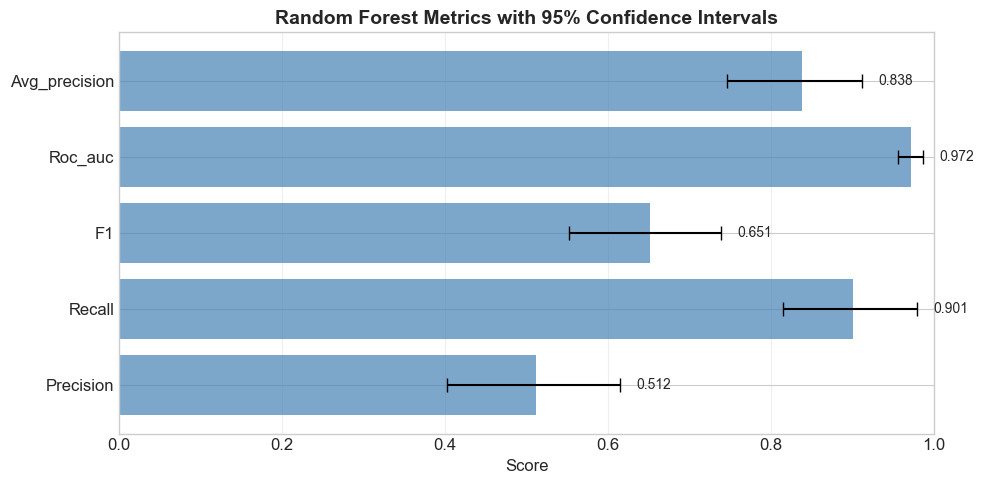

In [14]:
def bootstrap_metrics(y_true, y_probs, threshold, n_bootstrap=1000, random_state=42):
    """Calculate bootstrap confidence intervals for classification metrics."""
    np.random.seed(random_state)
    n_samples = len(y_true)
    
    metrics = {
        'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'avg_precision': []
    }
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        probs_boot = y_probs[indices]
        preds_boot = (probs_boot >= threshold).astype(int)
        
        # Skip if no positive class in bootstrap sample
        if y_boot.sum() == 0 or preds_boot.sum() == 0:
            continue
            
        metrics['precision'].append(precision_score(y_boot, preds_boot, zero_division=0))
        metrics['recall'].append(recall_score(y_boot, preds_boot))
        metrics['f1'].append(f1_score(y_boot, preds_boot, zero_division=0))
        metrics['roc_auc'].append(roc_auc_score(y_boot, probs_boot))
        metrics['avg_precision'].append(average_precision_score(y_boot, probs_boot))
    
    return metrics

# Calculate bootstrap CIs for Random Forest
print("Bootstrap 95% Confidence Intervals (Random Forest)")
print("=" * 60)

rf_probs = predictions['Random Forest']['probs']
rf_thresh = predictions['Random Forest']['threshold']
boot_metrics = bootstrap_metrics(y_test, rf_probs, rf_thresh)

ci_results = []
for metric_name, values in boot_metrics.items():
    values = np.array(values)
    mean_val = np.mean(values)
    ci_low = np.percentile(values, 2.5)
    ci_high = np.percentile(values, 97.5)
    print(f"{metric_name.capitalize():15s}: {mean_val:.4f} [{ci_low:.4f} - {ci_high:.4f}]")
    ci_results.append({
        'Metric': metric_name.capitalize(),
        'Mean': mean_val,
        'CI_Low': ci_low,
        'CI_High': ci_high
    })

# Visualize confidence intervals
ci_df = pd.DataFrame(ci_results)
fig, ax = plt.subplots(figsize=(10, 5))

y_pos = range(len(ci_df))
ax.barh(y_pos, ci_df['Mean'], xerr=[ci_df['Mean'] - ci_df['CI_Low'], ci_df['CI_High'] - ci_df['Mean']], 
        color='steelblue', capsize=5, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df['Metric'])
ax.set_xlabel('Score', fontsize=12)
ax.set_title('Random Forest Metrics with 95% Confidence Intervals', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (mean, low, high) in enumerate(zip(ci_df['Mean'], ci_df['CI_Low'], ci_df['CI_High'])):
    ax.text(high + 0.02, i, f'{mean:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/confidence_intervals.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Classification Report for Best Model
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT - Random Forest (Final Model)")
print("=" * 60)

rf_preds = predictions['Random Forest']['preds']
print(classification_report(y_test, rf_preds, target_names=['Non-Fraud', 'Fraud']))


DETAILED CLASSIFICATION REPORT - Random Forest (Final Model)
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.91      0.95       491
       Fraud       0.51      0.90      0.65        50

    accuracy                           0.91       541
   macro avg       0.75      0.91      0.80       541
weighted avg       0.94      0.91      0.92       541



## 10. Summary & Conclusions

In [15]:
print("=" * 70)
print("FRAUD DETECTION MODEL EVALUATION SUMMARY")
print("=" * 70)

rf_probs = predictions['Random Forest']['probs']
rf_preds = predictions['Random Forest']['preds']

print(f"""
Dataset Statistics:
  - Training samples: {len(y_train):,}
  - Validation samples: {len(y_val):,}
  - Test samples: {len(y_test):,}
  - Fraud rate (test): {y_test.mean():.2%}

Final Model: Random Forest (Calibrated)
  - Threshold: {predictions['Random Forest']['threshold']:.4f}
  - Precision: {precision_score(y_test, rf_preds):.2%}
  - Recall: {recall_score(y_test, rf_preds):.2%}
  - F1-Score: {f1_score(y_test, rf_preds):.2%}
  - ROC AUC: {roc_auc_score(y_test, rf_probs):.4f}
  - Average Precision: {average_precision_score(y_test, rf_probs):.4f}

Key Insights:
  - Random Forest selected for best balance of precision and recall
  - Threshold tuned to achieve high recall (catching most fraud)
  - Calibration applied for reliable probability estimates
""")
print("=" * 70)

FRAUD DETECTION MODEL EVALUATION SUMMARY

Dataset Statistics:
  - Training samples: 4,328
  - Validation samples: 541
  - Test samples: 541
  - Fraud rate (test): 9.24%

Final Model: Random Forest (Calibrated)
  - Threshold: 0.2014
  - Precision: 51.14%
  - Recall: 90.00%
  - F1-Score: 65.22%
  - ROC AUC: 0.9722
  - Average Precision: 0.8370

Key Insights:
  - Random Forest selected for best balance of precision and recall
  - Threshold tuned to achieve high recall (catching most fraud)
  - Calibration applied for reliable probability estimates

